In [24]:
from scipy.io import loadmat
#loading in dataset
path = './data/mnist-original.mat'
mnist = loadmat(path)
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [35]:
from numpy import swapaxes
#reshaping
X,y = mnist['data'],mnist['label'][0]
X = swapaxes(X,1,0)
print (X.shape, y.shape)

(70000, 784) (70000,)


In [61]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
def printImage(x):
    '''
    prints the image of a given digit
    '''
    some_digit = x.reshape(28,28)
    plt.imshow(some_digit, cmap = matplotlib.cm.binary,
           interpolation="nearest")
    plt.axis("off")
    plt.show()

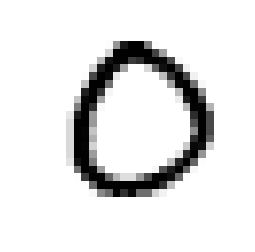

0.0


In [62]:
#verifying data set is correct
printImage(X[3601])
print(y[3601])

In [199]:
#splitting into train and test data sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
import numpy as np
shuffle_perm = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_perm], y_train[shuffle_perm]

(60000, 784)

In [47]:
#4-not-4 classifier
y_train_4 = (y_train == 4) #true for all 4, flase for all other digits
y_test_4 = (y_test == 4)

from sklearn.linear_model import SGDClassifier as sgdc
sgdc_4 = sgdc(random_state=42)
sgdc_4.fit(X_train, y_train_4)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

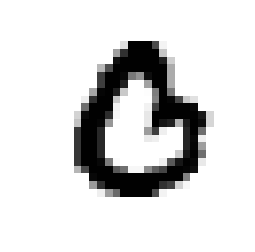

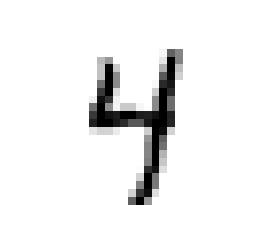

array([False,  True])

In [130]:
#a random first numer
rand_val = np.random.randint(low=0,high=60000)
val_1 = X_train[rand_val]
printImage(val_1)

#a random second numer
rand_val = np.random.randint(low=0,high=60000)
val_2 = X_train[rand_val]
printImage(val_2)

sgdc_4.predict([val_1, val_2])

In [128]:
#measuring accuracy
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgdc_4, X_train, y_train_4, cv=3)
np.unique(y_train_pred,return_counts=True)

(array([False,  True]), array([53988,  6012]))

In [172]:
from sklearn.metrics import confusion_matrix #very confused
confusion = confusion_matrix(y_train_4, y_train_pred)
print(confusion)
print("First row considers non 4 values, ",confusion[0][0],"of them were correctly classified as not 4 while",\
      confusion[0][1],"were wrongly classified as 4. 2nd row is all values that were 4",confusion[1][0],\
      "were wrongly classified as not 4 while",confusion[1][1],"were correctly classified as 4.")
def get_scores(y_train, y_pred):
    '''
    y train - expected values
    y pred - model given values
    returns recall, precision, fscore
    '''
    confusion = confusion_matrix(y_train, y_pred)
    fp = confusion[0][1] # false_positive
    fn = confusion[1][0] #false_negative
    tp = confusion[1][1] #true_positive
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    fscore = 2/((1/precision)+(1/recall))
    return (precision, recall, fscore)

[[53247   911]
 [  741  5101]]
First row considers non 4 values,  53247 of them were correctly classified as not 4 while 911 were wrongly classified as 4. 2nd row is all values that were 4 741 were wrongly classified as not 4 while 5101 were correctly classified as 4.


In [159]:
precision, recall, fscore = get_scores(y_train_4, y_train_pred)
print("Precision (When claiming it sees a 4, is correct):", (precision*100), "% of time.\nRecall(Model catches):"\
      ,(recall*100),"% of fours.\nF-score of:",fscore)

Precision (When claiming it sees a 4, is correct): 84.84697272122422 % of time.
Recall(Model catches): 87.31598767545361 % of fours.
F-score of: 0.8606377594061078


In [174]:
#finding precision and recall at all possible thresholds
#the decision score for each value
y_train_decision = cross_val_predict(sgdc_4, X_train, y_train_4, cv=3, method = "decision_function")
from sklearn.metrics import precision_recall_curve as prc
precisions, recalls, thresholds = prc(y_train_4, y_train_decision)
print(y_train_decision)

[-1198973.42539249  -554185.22275959  -262615.57391436 ...
  -435761.25085804  -835786.62348743  -543732.38576083]


In [139]:
from sklearn.metrics import roc_auc_score
#perfect classifier area under true_positive_rate v false_positive_rate equals 1
roc_auc_score(y_train_4, y_train_decision)

0.986683680886585

In [141]:
from sklearn.ensemble import RandomForestClassifier as rfc
forest_clf = rfc(random_state=42)

In [146]:
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_4, cv=3, method="predict_proba") \
#same thing as decision_func except gives a matrix with probability it thinks a image is each value

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [175]:
y_forest_decision = y_prob_forest[:,1]
roc_auc_score(y_train_4, y_forest_decision)

0.9938371136406026

In [197]:
threshold = 0.5 #value between 0 and 1, interesting to see how precision and recall fluctuate when threshold changes
y_decision_threshold = y_forest_decision>threshold
np.unique((y_decision_threshold),return_counts=True)

(array([False,  True]), array([55078,  4922]))

In [198]:
precision, recall, fscore = get_scores(y_train_4, y_decision_threshold)
print("Precision (When claiming it sees a 4, is correct):", (precision*100), "% of time.\nRecall(Model catches):"\
      ,(recall*100),"% of fours.\nF-score of:",fscore)

Precision (When claiming it sees a 4, is correct): 98.7403494514425 % of time.
Recall(Model catches): 83.19068812050668 % of fours.
F-score of: 0.9030100334448159


In [202]:
#0-9 general classifier
sgdc_general = sgdc(random_state=42)
sgdc_general.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

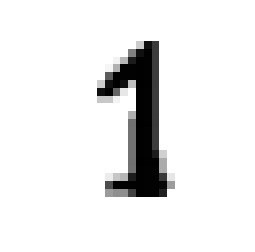

array([1.])

In [208]:
#0-9 general classifier in action
rand_val = np.random.randint(low=0,high=60000)
val_1 = X_train[rand_val]
printImage(val_1)
sgdc_general.predict([val_1])

[[0.  0.7 0.  0.  0.  0.  0.  0.1 0.2 0. ]]


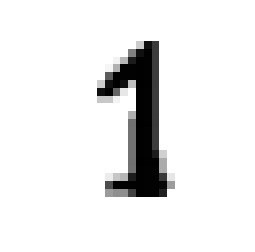

In [211]:
forest_clf.fit(X_train, y_train)
print(forest_clf.predict_proba([val_1]))
printImage(val_1)

In [220]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.00441808, -0.00575482, -0.00408252,
       -0.00408252,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.00408252, -0.00470969, -0.00879935,
       -0.01159056, -0.01475898, -0.01928485, -0.0246718 , -0.02907103,
       -0.03059266, -0.03116401, -0.03196287, -0.03020254, -0.03131022,
       -0.0283834 , -0.02311919, -0.01916663, -0.0167723 , -0.01099636,
       -0.00832486, -0.00438069,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.00408252, -0.00539535,
       -0.00852241, -0.01198504, -0.01765348, -0.0277109 , -0.03702009,
       -0.05215128, -0.0670362 , -0.08301705, -0.0993793 , -0.11

In [221]:
y_train_pred = cross_val_predict(sgdc_general, X_train_scaled, y_train, cv=3)
general_mx = confusion_matrix(y_train, y_train_pred)
general_mx

array([[5733,    4,   13,   11,   13,   55,   42,    8,   40,    4],
       [   2, 6502,   45,   23,    6,   40,    5,   10,   96,   13],
       [  50,   38, 5317,  117,   82,   29,   91,   58,  163,   13],
       [  47,   46,  127, 5317,    2,  250,   35,   58,  156,   93],
       [  20,   29,   34,    9, 5351,    8,   56,   32,   83,  220],
       [  68,   45,   31,  184,   76, 4614,  103,   30,  188,   82],
       [  32,   29,   43,    2,   42,   93, 5624,    7,   46,    0],
       [  21,   23,   70,   29,   52,   12,    5, 5807,   14,  232],
       [  50,  163,   72,  153,   11,  156,   49,   27, 5041,  129],
       [  44,   37,   25,   81,  169,   39,    2,  214,   84, 5254]])

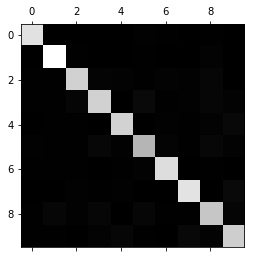

In [225]:
plt.matshow(general_mx, cmap=plt.cm.gray)
plt.show()